1. Kết hợp dữ liệu từ các bảng rời rạc

In [ ]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Đọc file CSV từ thư mục /kaggle/input/
userlog = pd.read_csv('/kaggle/input/dazone-2025/user_log.csv')
userinfo = pd.read_csv('/kaggle/input/dazone-2025/user_info.csv')
train = pd.read_csv('/kaggle/input/dazone-2025/train.csv')
test = pd.read_csv('/kaggle/input/dazone-2025/test.csv')

In [181]:
#Kiểm tra sơ bộ dữ liệu
print("Thông tin User Info: ")
print(userinfo.info())

print("Thông tin User Log: ")
print(userlog.info())

Thông tin User Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         424170 non-null  int64  
 1   age             328803 non-null  float64
 2   sex             418652 non-null  object 
 3   phone           402962 non-null  object 
 4   job             402962 non-null  object 
 5   carrier         402962 non-null  object 
 6   marital_status  423813 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 22.7+ MB
None
Thông tin User Log: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   brand_id     float64
 4   merchant_id  int64  
 5   action       object 
 6   datetime     object 
dtypes: float64(1

In [182]:
#Kiểm tra chi tiết bộ User Log
print ("5 dòng đầu dữ liệu: ")
print(userlog.head())

5 dòng đầu dữ liệu: 
   user_id  item_id  cat_id  brand_id  merchant_id action    datetime
0   328862   323294     833    2661.0         2882  click  2024-08-29
1   328862   844400    1271    2661.0         2882  click  2024-08-29
2   328862   575153    1271    2661.0         2882  click  2024-08-29
3   328862   996875    1271    2661.0         2882  click  2024-08-29
4   328862  1086186    1271    1049.0         1253  click  2024-08-29


In [183]:
#Chuyển kiểu của cột datetime từ string -> datetime
userlog['datetime'] = pd.to_datetime(userlog['datetime'], format='%Y-%m-%d')
print(userlog.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   cat_id       int64         
 3   brand_id     float64       
 4   merchant_id  int64         
 5   action       object        
 6   datetime     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.9+ GB
None


In [184]:
# Bảng đếm hành vi
log_agg = userlog.groupby(['user_id', 'merchant_id', 'action'])['item_id'] \
                 .count() \
                 .unstack(fill_value=0) \
                 .reset_index()

# Bảng thời gian tương tác gần nhất
recent_time = userlog.groupby(['user_id', 'merchant_id'])['datetime'].max().reset_index()

# Gộp vào bảng hành vi
log_agg = pd.merge(log_agg, recent_time, on=['user_id', 'merchant_id'], how='left')

In [185]:
## Kết hợp hành vi với label
data = pd.merge(train, log_agg, on=['user_id', 'merchant_id'], how='left')
# Kết hợp thêm đặc điểm nhân khẩu học
data = pd.merge(data, userinfo, on='user_id', how='left')

2. Khám phá dữ liệu sau kết hợp 

In [186]:
#Xem thông tin tổng quan về dữ liệu
print(data.info())
print("--------------------------------------")

# xem mô tả
print(data.describe())
print("--------------------------------------")

#Xem kích thước dữ liệu
print(data.shape)
print("--------------------------------------")

#Kiểm tra tổng giá trị null theo từng cột
print(data.isnull().sum())
print("--------------------------------------")

#Xem 5 dòng đầu dữ liệu
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233782 entries, 0 to 233781
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         228192 non-null  float64       
 1   merchant_id     228284 non-null  float64       
 2   label           233782 non-null  float64       
 3   add-to-cart     221145 non-null  float64       
 4   click           221145 non-null  float64       
 5   favourite       221145 non-null  float64       
 6   purchase        221145 non-null  float64       
 7   datetime        221145 non-null  datetime64[ns]
 8   age             175677 non-null  float64       
 9   sex             221542 non-null  object        
 10  phone           213119 non-null  object        
 11  job             213221 non-null  object        
 12  carrier         213216 non-null  object        
 13  marital_status  224338 non-null  object        
dtypes: datetime64[ns](1), float64(8), ob

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


3. Làm sạch dữ liệu

3.1. Xóa tất cả các giá trị null

In [187]:
data = data.dropna()
print(data.shape)

(146370, 14)


3.2. Loại bỏ cột phone vì không cần thiết 

In [188]:
data = data.drop(columns=['phone'])
print(data.shape)
print(data.columns)

(146370, 13)
Index(['user_id', 'merchant_id', 'label', 'add-to-cart', 'click', 'favourite',
       'purchase', 'datetime', 'age', 'sex', 'job', 'carrier',
       'marital_status'],
      dtype='object')


3.3. Gom nhóm các giá trị trong các cột dạng chuỗi

In [189]:
#Cột sex
#Kiểm tra xem có những nhãn nào
print(data['sex'].unique())

['she' 'female' 'lady' 'male' 'woman' 'girl' 'he' 'F' 'mаle' 'M' 'boy'
 'gentle' 'other' 'men' 'unknown' 'gіrl' 'wοman' 'mеn' 'bοy' 'womаn'
 'սnknown' 'femаle' 'nսll' 'lаdy' 'shе' 'fеmale' 'gеntle' 'hе' 'othеr'
 'femalе' 'malе' 'οther' 'gentlе' 'unknοwn' 'femаlе' 'fеmalе']


In [190]:
# Bước 1: Định nghĩa ánh xạ để chuẩn hóa giá trị giới tính
sex_mapping = {
    'gentle': 'Male', 'gеntle': 'Male', 'gentlе': 'Male',  # Các biến thể của 'gentle'
    'lady': 'Female', 'lаdy': 'Female',  # Các biến thể của 'lady'
    'she': 'Female', 'shе': 'Female',  # Các biến thể của 'she'
    'female': 'Female', 'fеmale': 'Female', 'femаle': 'Female', 'femalе': 'Female', 'fеmalе': 'Female', 'fеmаle': 'Female',  # Các biến thể của 'female'
    'girl': 'Female', 'gіrl': 'Female',  # Các biến thể của 'girl'
    'male': 'Male', 'M': 'Male', 'mаle': 'Male', 'malе': 'Male', 'mаlе': 'Male',  # Các biến thể của 'male'
    'boy': 'Male', 'bοy': 'Male',  # Các biến thể của 'boy'
    'woman': 'Female', 'wοman': 'Female', 'womаn': 'Female', 'wοmаn': 'Female',  # Các biến thể của 'woman'
    'F': 'Female',  # Viết tắt của 'Female'
    'he': 'Male', 'hе': 'Male',  # Các biến thể của 'he'
    'men': 'Male', 'mеn': 'Male',  # Các biến thể của 'men'
    'unknown': 'Unknown', 'սnknown': 'Unknown', 'unknοwn': 'Unknown',  # Các biến thể của 'unknown'
    'other': 'Other', 'othеr': 'Other', 'οther': 'Other',  # Các biến thể của 'other'
    'nսll': 'Unknown'  # Xem 'null' như 'Unknown'
}

# Bước 2: Áp dụng ánh xạ để chuẩn hóa cột sex
data['sex'] = data['sex'].map(sex_mapping).fillna('Unknown')  # Ánh xạ và gán NaN thành 'Unknown'

# Bước 3: Tính mode của các giá trị đã chuẩn hóa (loại trừ 'Unknown' và 'Other')
mode_sex = data[data['sex'].isin(['Female', 'Male'])]['sex'].mode()[0]

# Bước 4: Thay thế 'Unknown' và 'Other' bằng mode
data['sex'] = data['sex'].replace(['Unknown', 'Other'], mode_sex)

#Kiểm tra lại nhãn sau khi đồng nhất
print(data['sex'].unique())

['Female' 'Male']


In [191]:
#Cột job
#Kiểm tra xem có những nhãn nào
print(data['job'].unique())

['Kỹ sư xây dựng' 'Nhà báo' 'Nhân viên kinh doanh' 'Chuyên viên bảo mật'
 'Nhân viên lễ tân' 'Kiến trúc sư phần mềm' 'Kiểm toán'
 'Thực tập sinh giáo dục' 'Kiến trúc sư' 'UX/UI Designer' 'Nghệ sĩ'
 'Kỹ sư phần mềm' 'Y tá' 'Chuyên viên tư vấn tuyển sinh'
 'Nhân viên nhà hàng' 'Giáo viên' 'Trưởng phòng kinh doanh' 'Nông dân'
 'Chuyên viên bán hàng trực tuyến' 'Nhà tư vấn tài chính' 'Giảng viên'
 'Thợ xây' 'Project Manager' 'Chuyên viên nhân sự' 'Kỹ sư nông nghiệp'
 'Nhà thiết kế đồ họa' 'Công nhân sản xuất' 'Kỹ sư sản xuất' 'Điều Dưỡng'
 'Thư ký pháp lý' 'Luật sư' 'Nhân viên khách sạn' 'Quản lý sản xuất'
 'Lập trình viên' 'Kỹ sư giám sát' 'DevOps Engineer' 'Tư vấn khách hàng'
 'Dược sĩ' 'Chuyên viên tín dụng' 'Marketing Manager'
 'Sales Representative' 'Thực Tập' 'Digital Marketer'
 'Nhà phân tích dữ liệu' 'Giám đốc kinh doanh' 'Kế toán'
 'Nhân viên ngân hàng' 'Chuyên viên phân tích thị trường' 'Tester'
 'Biên dịch viên' 'Bác sĩ' 'Nhân viên hành chính' 'Nhân Viên Bán Hàng']


In [192]:
# Bước 1: Định nghĩa ánh xạ để chuyển các công việc sang tiếng Anh
job_mapping = {
    'Thực tập sinh giáo dục': 'Education Intern',
    'DevOps Engineer': 'DevOps Engineer',
    'Kiến trúc sư phần mềm': 'Software Architect',
    'UX/UI Designer': 'UX/UI Designer',
    'Trưởng phòng kinh doanh': 'Sales Manager',
    'Lập trình viên': 'Programmer',
    'Nhà phân tích dữ liệu': 'Data Analyst',
    'Y tá': 'Nurse',
    'Quản lý sản xuất': 'Production Manager',
    'Kỹ sư giám sát': 'Supervisory Engineer',
    'Digital Marketer': 'Digital Marketer',
    'Nghệ sĩ': 'Artist',
    'Thực Tập': 'Intern',
    'Điều Dưỡng': 'Nurse',
    'Kiến trúc sư': 'Architect',
    'Nông dân': 'Farmer',
    'Chuyên viên nhân sự': 'HR Specialist',
    'Nhân viên kinh doanh': 'Sales Representative',
    'Nhân viên hành chính': 'Administrative Staff',
    'Nhà báo': 'Journalist',
    'Nhân viên nhà hàng': 'Restaurant Staff',
    'Bác sĩ': 'Doctor',
    'Chuyên viên tư vấn tuyển sinh': 'Admissions Counselor',
    'Kỹ sư nông nghiệp': 'Agricultural Engineer',
    'Thợ xây': 'Construction Worker',
    'Giảng viên': 'Lecturer',
    'Chuyên viên bảo mật': 'Security Specialist',
    'Kỹ sư xây dựng': 'Civil Engineer',
    'Kỹ sư phần mềm': 'Software Engineer',
    'Nhà thiết kế đồ họa': 'Graphic Designer',
    'Project Manager': 'Project Manager',
    'Nhà tư vấn tài chính': 'Financial Consultant',
    'Nhân viên khách sạn': 'Hotel Staff',
    'Kiểm toán': 'Auditor',
    'Thư ký pháp lý': 'Legal Secretary',
    'Công nhân sản xuất': 'Production Worker',
    'Nhân viên lễ tân': 'Receptionist',
    'Chuyên viên tín dụng': 'Credit Specialist',
    'Giáo viên': 'Teacher',
    'Sales Representative': 'Sales Representative',
    'Tester': 'Tester',
    'Kỹ sư sản xuất': 'Manufacturing Engineer',
    'Luật sư': 'Lawyer',
    'Chuyên viên bán hàng trực tuyến': 'Online Sales Specialist',
    'Chuyên viên phân tích thị trường': 'Market Analyst',
    'Nhân Viên Bán Hàng': 'Sales Representative',
    'Giám đốc kinh doanh': 'Sales Director',
    'Biên dịch viên': 'Translator',
    'Dược sĩ': 'Pharmacist',
    'Nhân viên ngân hàng': 'Bank Employee',
    'Tư vấn khách hàng': 'Customer Service Representative',
    'Marketing Manager': 'Marketing Manager',
    'Kế toán': 'Accountant'
}

# Bước 2: Định nghĩa ánh xạ để phân loại công việc vào các lĩnh vực
job_category_mapping = {
    'Education Intern': 'Education',
    'DevOps Engineer': 'Technology',
    'Software Architect': 'Technology',
    'UX/UI Designer': 'Design',
    'Sales Manager': 'Sales',
    'Programmer': 'Technology',
    'Data Analyst': 'Data Analysis',
    'Nurse': 'Healthcare',
    'Production Manager': 'Manufacturing',
    'Supervisory Engineer': 'Engineering',
    'Digital Marketer': 'Marketing',
    'Artist': 'Arts',
    'Intern': 'General',
    'Architect': 'Architecture',
    'Farmer': 'Agriculture',
    'HR Specialist': 'Human Resources',
    'Sales Representative': 'Sales',
    'Administrative Staff': 'Administration',
    'Journalist': 'Media',
    'Restaurant Staff': 'Hospitality',
    'Doctor': 'Healthcare',
    'Admissions Counselor': 'Education',
    'Agricultural Engineer': 'Agriculture',
    'Construction Worker': 'Construction',
    'Lecturer': 'Education',
    'Security Specialist': 'Technology',
    'Civil Engineer': 'Engineering',
    'Software Engineer': 'Technology',
    'Graphic Designer': 'Design',
    'Project Manager': 'Management',
    'Financial Consultant': 'Finance',
    'Hotel Staff': 'Hospitality',
    'Auditor': 'Finance',
    'Legal Secretary': 'Legal',
    'Production Worker': 'Manufacturing',
    'Receptionist': 'Administration',
    'Credit Specialist': 'Finance',
    'Teacher': 'Education',
    'Tester': 'Technology',
    'Manufacturing Engineer': 'Engineering',
    'Lawyer': 'Legal',
    'Online Sales Specialist': 'Sales',
    'Market Analyst': 'Marketing',
    'Sales Director': 'Sales',
    'Translator': 'Language Services',
    'Pharmacist': 'Healthcare',
    'Bank Employee': 'Finance',
    'Customer Service Representative': 'Customer Service',
    'Marketing Manager': 'Marketing',
    'Accountant': 'Finance'
}

# Bước 3: Áp dụng ánh xạ để chuyển đổi sang tiếng Anh
data['job'] = data['job'].map(job_mapping).fillna('Unknown')

# Bước 4: Phân loại công việc vào các lĩnh vực
data['job'] = data['job'].map(job_category_mapping).fillna('Unknown')

# Bước 5: Tính mode của lĩnh vực (loại trừ 'Unknown')
mode_category = data[data['job'] != 'Unknown']['job'].mode()[0]

# Bước 6: Thay thế 'Unknown' bằng mode
data['job'] = data['job'].replace('Unknown', mode_category)

# Bước 7: Kiểm tra các giá trị trong cột job sau khi làm sạch
print("\nCác giá trị duy nhất trong cột job sau khi làm sạch:")
print(data['job'].unique())



Các giá trị duy nhất trong cột job sau khi làm sạch:
['Engineering' 'Media' 'Sales' 'Technology' 'Administration' 'Finance'
 'Education' 'Architecture' 'Design' 'Arts' 'Healthcare' 'Hospitality'
 'Agriculture' 'Construction' 'Management' 'Human Resources'
 'Manufacturing' 'Legal' 'Customer Service' 'Marketing' 'General'
 'Data Analysis' 'Language Services']


In [193]:
import numpy as np
# Bước 1: Thay thế giá trị 'nan' (chuỗi) và NaN bằng 'other'
data['carrier'] = data['carrier'].replace(['nan', np.nan], 'other')

# Bước 2: Kiểm tra các giá trị duy nhất trong cột carrier sau khi làm sạch
print("\nCác giá trị duy nhất trong cột carrier sau khi làm sạch:")
print(data['carrier'].unique())


Các giá trị duy nhất trong cột carrier sau khi làm sạch:
['viettel' 'other' 'vietnamobile' 'mobiphone' 'vinaphone']


In [194]:
#Kiểm tra xem cột marital_status có những giá trị nào
print(data["marital_status"].unique())

['Married' 'Single' 'cưới' 'Unmarried' 'độc thân' 'ly hôn' 'Divorced']


In [195]:
data['marital_status'] = data['marital_status'].replace({
    'cưới': 'Married',
    'độc thân': 'Single',
    'Unmarried': 'Single',
    'ly hôn': 'Divorced'
})
data = data.dropna(subset=['marital_status'])

print(data["marital_status"].unique())

['Married' 'Single' 'Divorced']


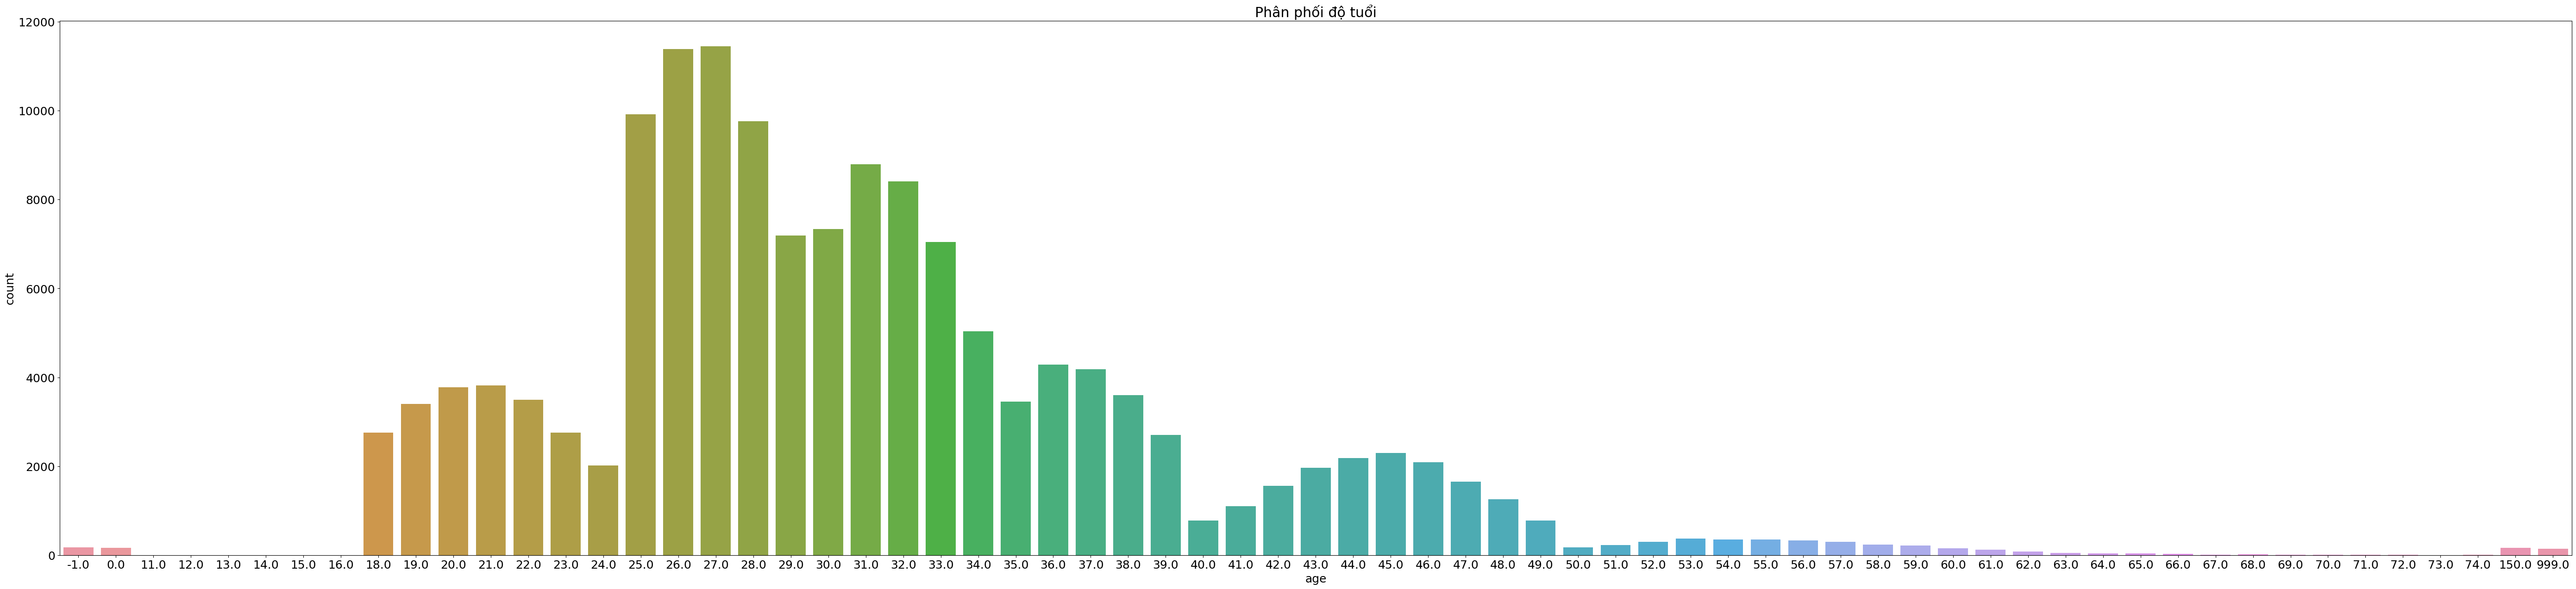

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
#Xem phân phối dữ liệu cho cột tuổi
plt.rcParams['figure.figsize'] = (70, 15)
sns.countplot(x='age', data=data)
plt.title('Phân phối độ tuổi')
plt.show()

In [197]:
#Xóa các giá trị ngoại lai
data.drop(data[data['age'].isin([-1, 0, 150, 999])].index, inplace=True)

In [198]:
print(data['add-to-cart'].unique())
print(data['click'].unique())
print(data['favourite'].unique())
print(data['purchase'].unique())

[ 0.  2.  1.  3.  4.  5.  7. 13.  6.  8.]
[6.000e+00 2.100e+01 9.000e+00 1.000e+00 4.000e+00 1.600e+01 5.000e+00
 0.000e+00 7.000e+00 1.000e+01 8.000e+00 3.000e+00 4.800e+01 3.100e+01
 2.000e+00 1.500e+01 2.700e+01 3.000e+01 4.000e+01 1.250e+02 3.900e+01
 1.700e+01 1.300e+01 1.400e+01 2.500e+01 3.700e+01 1.800e+01 1.200e+01
 4.400e+01 1.100e+01 2.400e+01 8.300e+01 8.000e+01 3.200e+01 2.800e+01
 2.900e+01 7.000e+01 5.200e+01 3.300e+01 2.200e+01 2.000e+01 3.400e+01
 1.900e+01 4.600e+01 7.100e+01 3.800e+01 2.460e+02 6.900e+01 3.600e+01
 2.300e+01 5.800e+01 7.700e+01 5.900e+01 1.270e+02 5.000e+01 1.240e+02
 6.100e+01 5.500e+01 4.900e+01 4.200e+01 5.100e+01 1.540e+02 5.300e+01
 2.600e+01 7.600e+01 4.300e+01 5.600e+01 6.600e+01 9.400e+01 6.400e+01
 6.200e+01 4.500e+01 6.500e+01 1.750e+02 2.770e+02 6.300e+01 8.500e+01
 6.700e+01 1.230e+02 1.100e+02 5.400e+01 9.000e+01 1.180e+02 7.300e+01
 2.280e+02 1.090e+02 1.570e+02 2.420e+02 2.740e+02 4.100e+01 1.510e+02
 3.500e+01 1.040e+02 1.020e+02 8.90

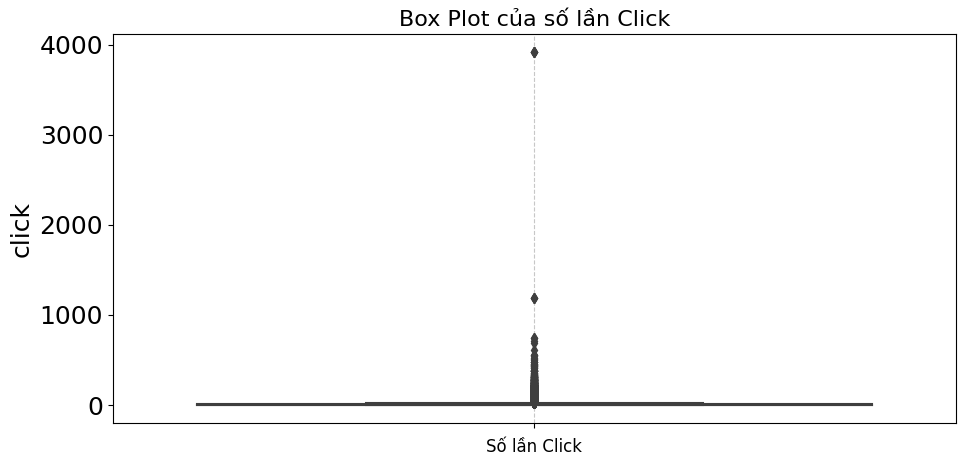

In [199]:
# ----------------- Vẽ Box Plot cho cột 'click' -----------------
plt.figure(figsize=(10, 5))
sns.boxplot(y=data['click'])
plt.title('Box Plot của số lần Click', fontsize=16)
plt.xlabel('Số lần Click', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [200]:
Q1 = data['click'].quantile(0.25)
Q3 = data['click'].quantile(0.75)
IQR = Q3 - Q1

# Giới hạn dưới và trên
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc bỏ outliers
data = data[(data['click'] >= lower_bound) & (data['click'] <= upper_bound)]

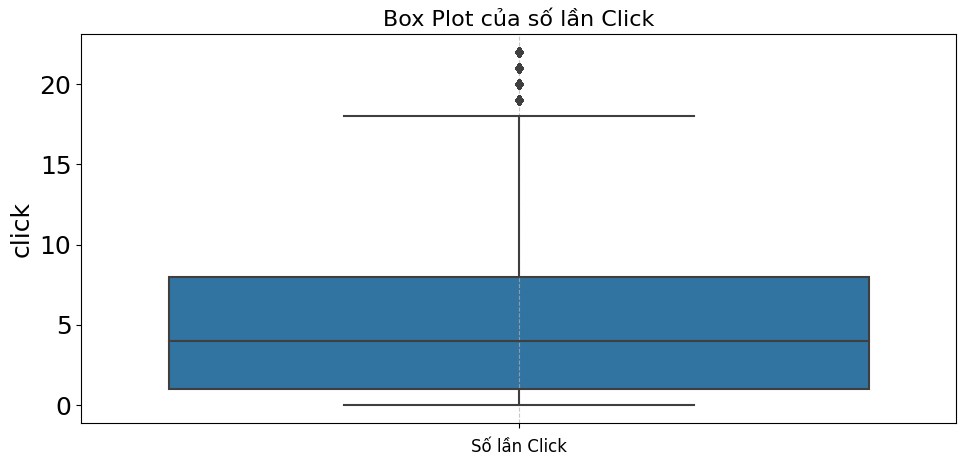

In [201]:
# ----------------- Vẽ Box Plot cho cột 'click' -----------------
plt.figure(figsize=(10, 5))
sns.boxplot(y=data['click'])
plt.title('Box Plot của số lần Click', fontsize=16)
plt.xlabel('Số lần Click', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [202]:
print(data['add-to-cart'].unique())
print(data['click'].unique())
print(data['favourite'].unique())
print(data['purchase'].unique())

[0. 2. 1. 4. 3. 5. 8. 7.]
[ 6. 21.  9.  1.  4. 16.  5.  0.  7. 10.  8.  3.  2. 15. 17. 13. 14. 18.
 12. 11. 22. 20. 19.]
[ 0.  1.  2.  3.  5.  4.  7.  9.  6. 10.  8. 14. 16. 13. 11. 12. 20. 18.
 19. 17. 25. 32. 15. 31. 23. 21.]
[ 2.  1.  4.  3.  7.  8.  5.  6.  9. 10.]


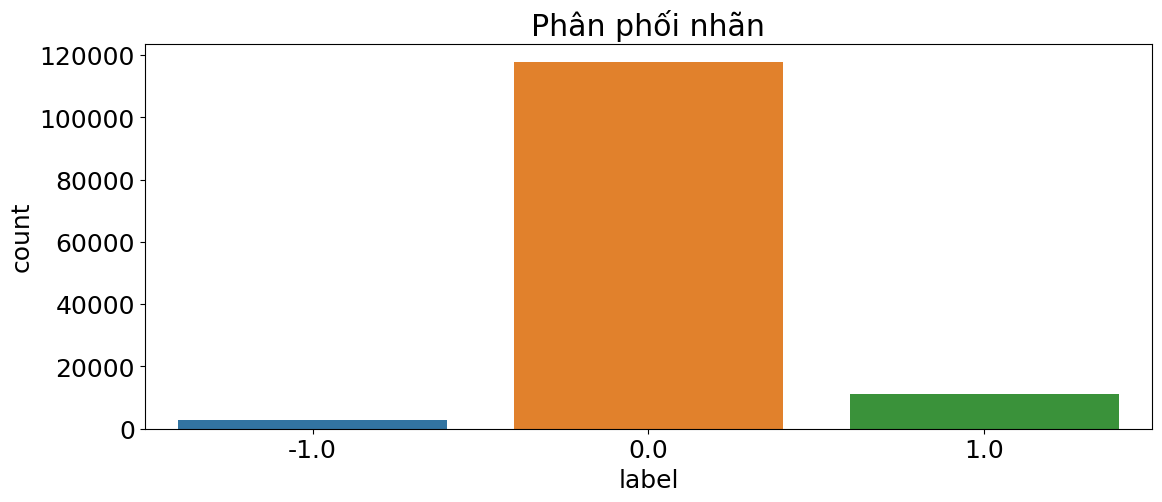

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
#Xem phân phối dữ liệu cho cột tuổi
plt.rcParams['figure.figsize'] = (13, 5)
sns.countplot(x='label', data=data)
plt.title('Phân phối nhãn')
plt.show()

In [204]:
#Xóa các nhãn -1 đi
data = data[data['label'] != -1]

In [205]:
print(data.shape)
print(data.head())

(129067, 13)
    user_id  merchant_id  label  add-to-cart  click  favourite  purchase  \
2  203618.0        598.0    0.0          0.0    6.0        0.0       2.0   
5  141726.0       1272.0    0.0          0.0   21.0        0.0       2.0   
6  117868.0        415.0    0.0          0.0    9.0        0.0       2.0   
7  170952.0        212.0    0.0          0.0    1.0        1.0       1.0   
9   96875.0       4048.0    0.0          0.0    4.0        0.0       1.0   

    datetime   age     sex             job       carrier marital_status  
2 2024-11-11  26.0  Female     Engineering       viettel        Married  
5 2024-11-11  33.0  Female           Media         other        Married  
6 2024-11-11  33.0  Female           Sales  vietnamobile         Single  
7 2024-11-11  31.0  Female      Technology       viettel        Married  
9 2024-11-11  31.0    Male  Administration  vietnamobile        Married  


In [206]:
import datetime
current_date = max(data['datetime'] + datetime.timedelta(days=1))
data['days_since_last_interaction'] = (current_date - data['datetime']).dt.days

In [207]:
print(data.head())

    user_id  merchant_id  label  add-to-cart  click  favourite  purchase  \
2  203618.0        598.0    0.0          0.0    6.0        0.0       2.0   
5  141726.0       1272.0    0.0          0.0   21.0        0.0       2.0   
6  117868.0        415.0    0.0          0.0    9.0        0.0       2.0   
7  170952.0        212.0    0.0          0.0    1.0        1.0       1.0   
9   96875.0       4048.0    0.0          0.0    4.0        0.0       1.0   

    datetime   age     sex             job       carrier marital_status  \
2 2024-11-11  26.0  Female     Engineering       viettel        Married   
5 2024-11-11  33.0  Female           Media         other        Married   
6 2024-11-11  33.0  Female           Sales  vietnamobile         Single   
7 2024-11-11  31.0  Female      Technology       viettel        Married   
9 2024-11-11  31.0    Male  Administration  vietnamobile        Married   

   days_since_last_interaction  
2                            2  
5                         

In [208]:
data = data.drop(columns=['datetime'])

3.4. Mã hóa các nhóm giá trị trong các cột kiểu string

In [209]:
#mã hóa cột sex
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Tạo LabelEncoder
le = LabelEncoder()

# Mã hóa cột chuỗi
data['sex'] = le.fit_transform(data['sex'])

#Mã hóa cột job
data['job'] = le.fit_transform(data['job'])

#Mã hóa cột carrier
data['carrier'] = le.fit_transform(data['carrier'])

#Mã hóa cột marital_status
data['marital_status'] = le.fit_transform(data['marital_status'])

In [210]:
data.to_csv('/kaggle/working/data.csv', index=False)
print("Đã lưu file merged thành tập data.csv")

Đã lưu file merged thành tập data.csv


4. Trực quan hóa dữ liệu

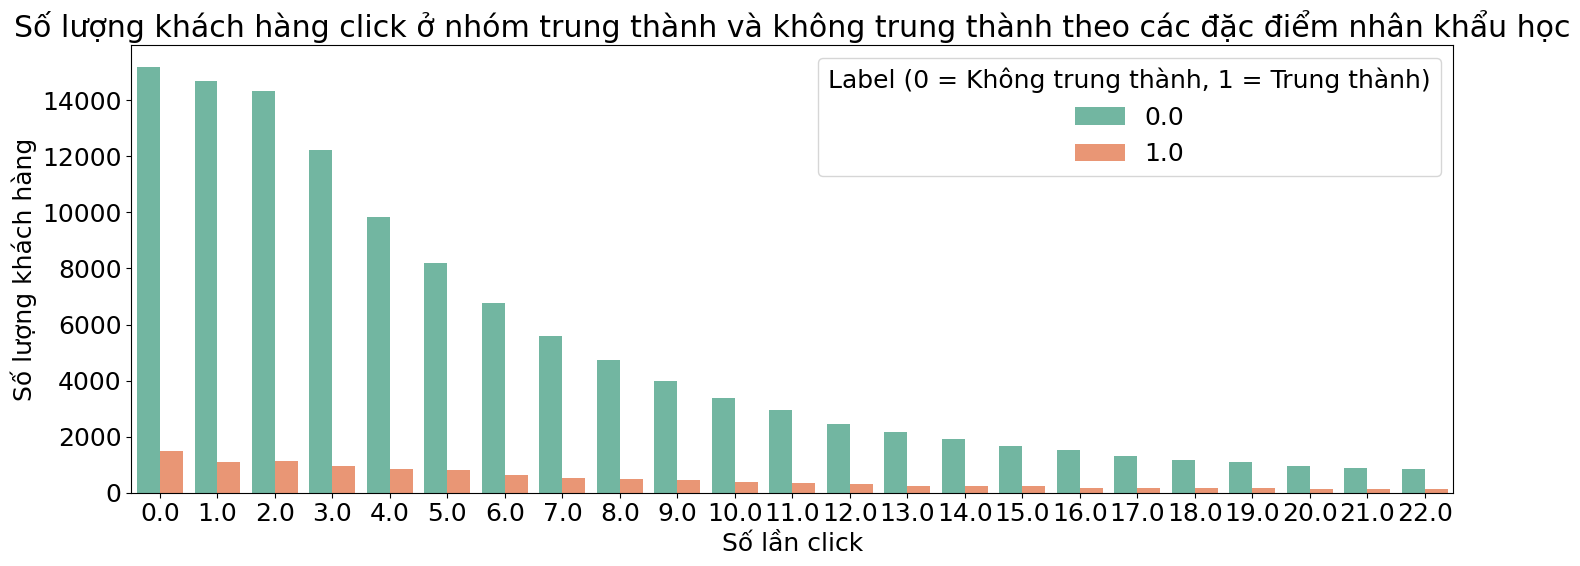

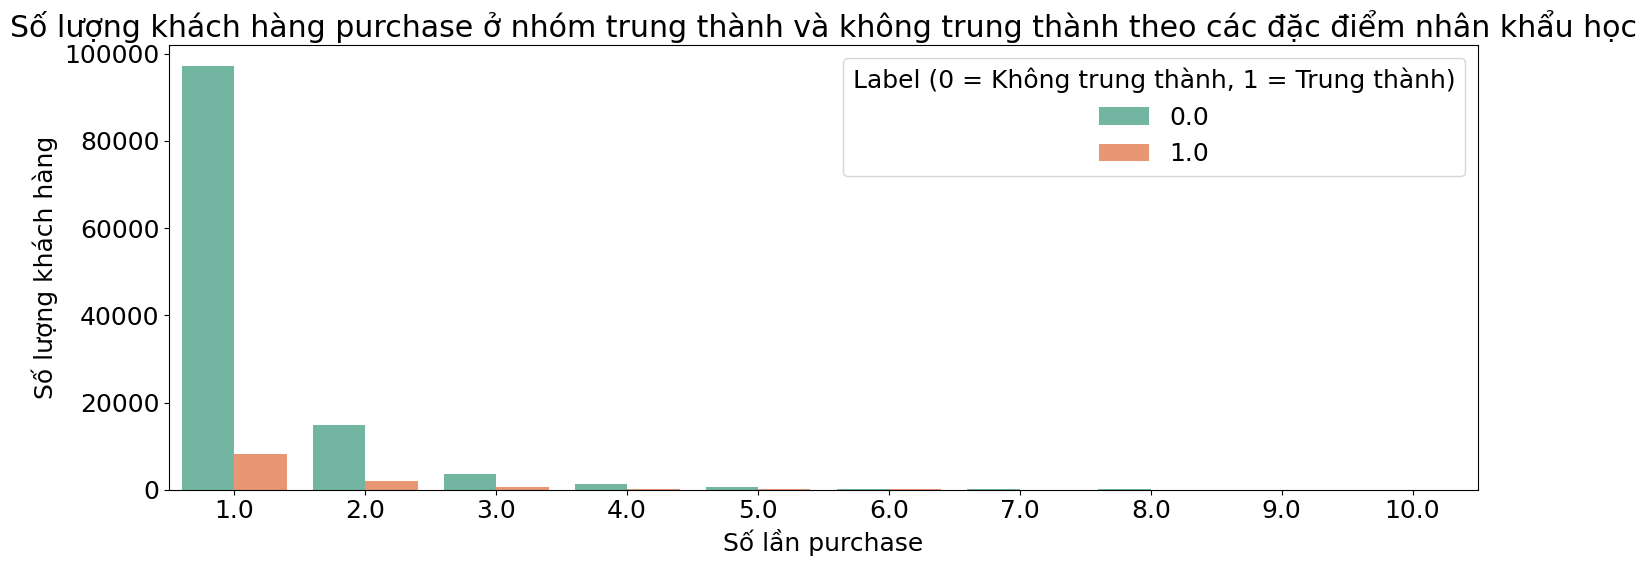

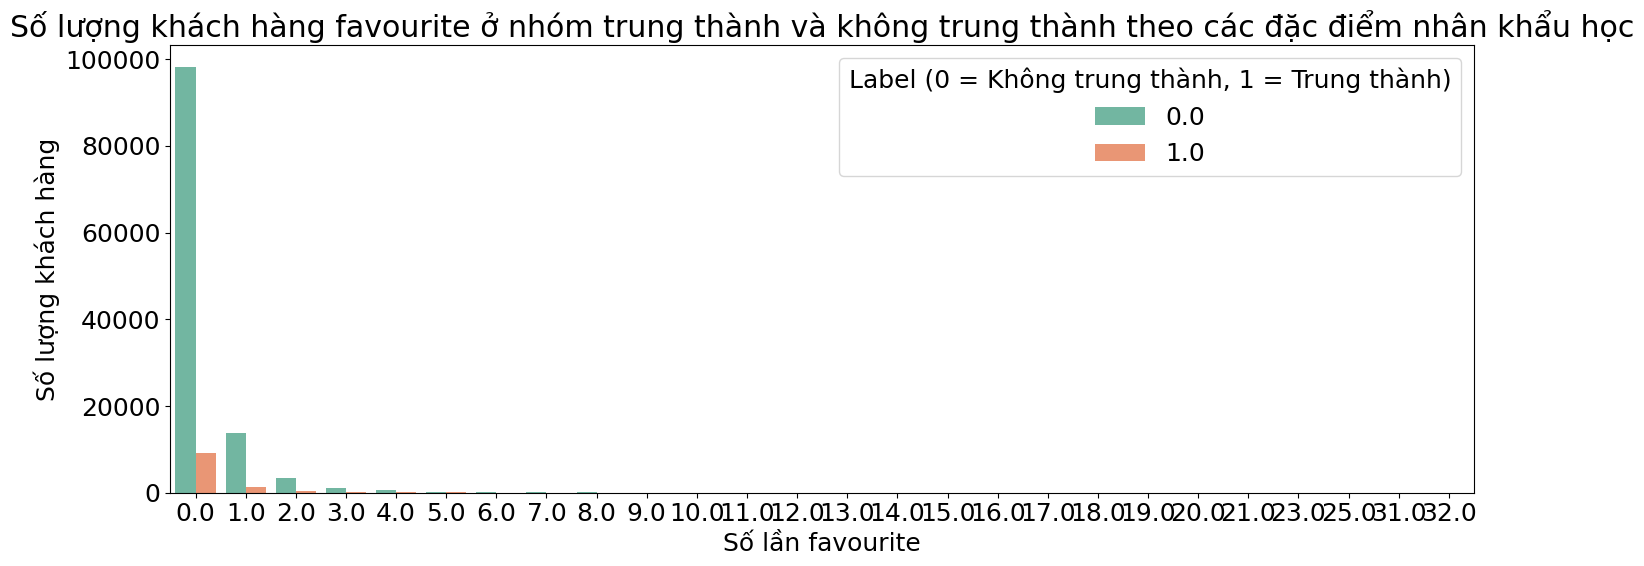

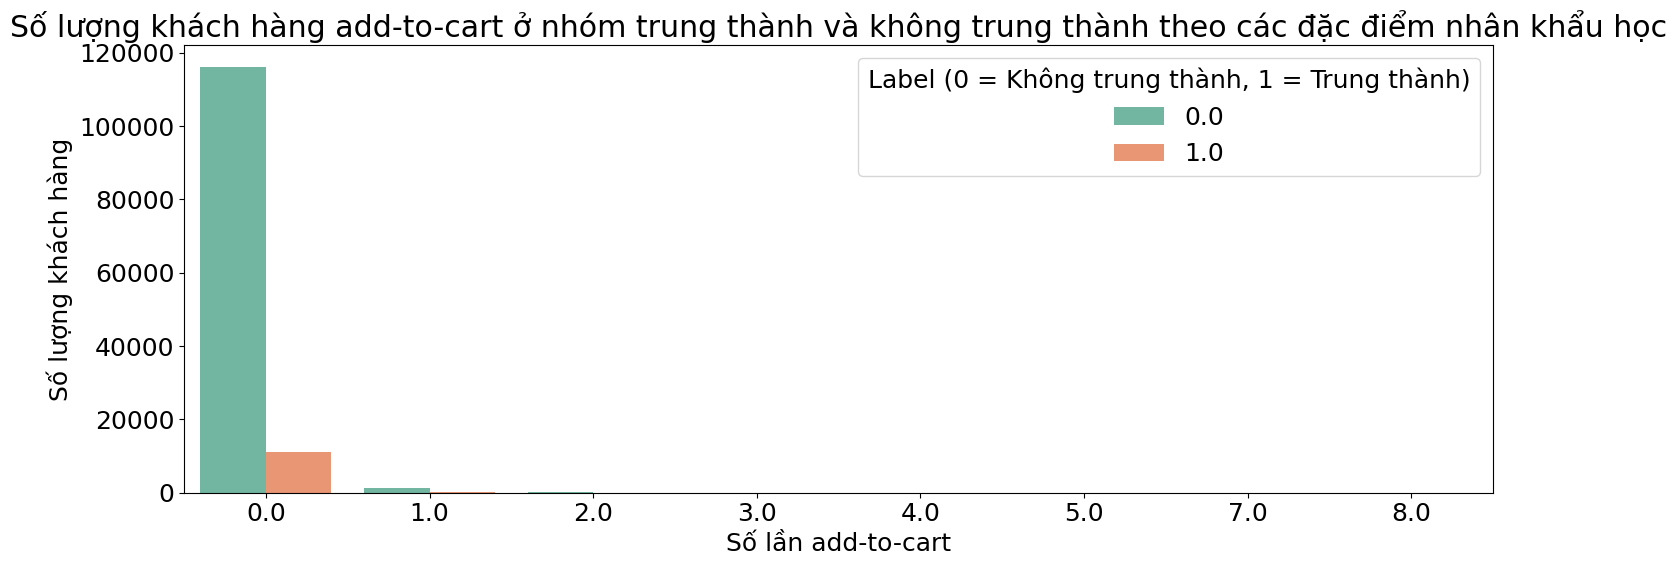

In [231]:
# Danh sách hành vi
behavior_columns = ['click', 'purchase', 'favourite', 'add-to-cart']

# Vẽ từng biểu đồ riêng biệt
for behavior in behavior_columns:
    plt.figure(figsize=(15, 6))
    sns.countplot(data=data, x=behavior, hue='label', palette='Set2')
    plt.title(f'Số lượng khách hàng {behavior} ở nhóm trung thành và không trung thành theo các đặc điểm nhân khẩu học')
    plt.xlabel(f'Số lần {behavior}')
    plt.ylabel('Số lượng khách hàng')
    plt.legend(title='Label (0 = Không trung thành, 1 = Trung thành)')
    plt.tight_layout()
    plt.show()


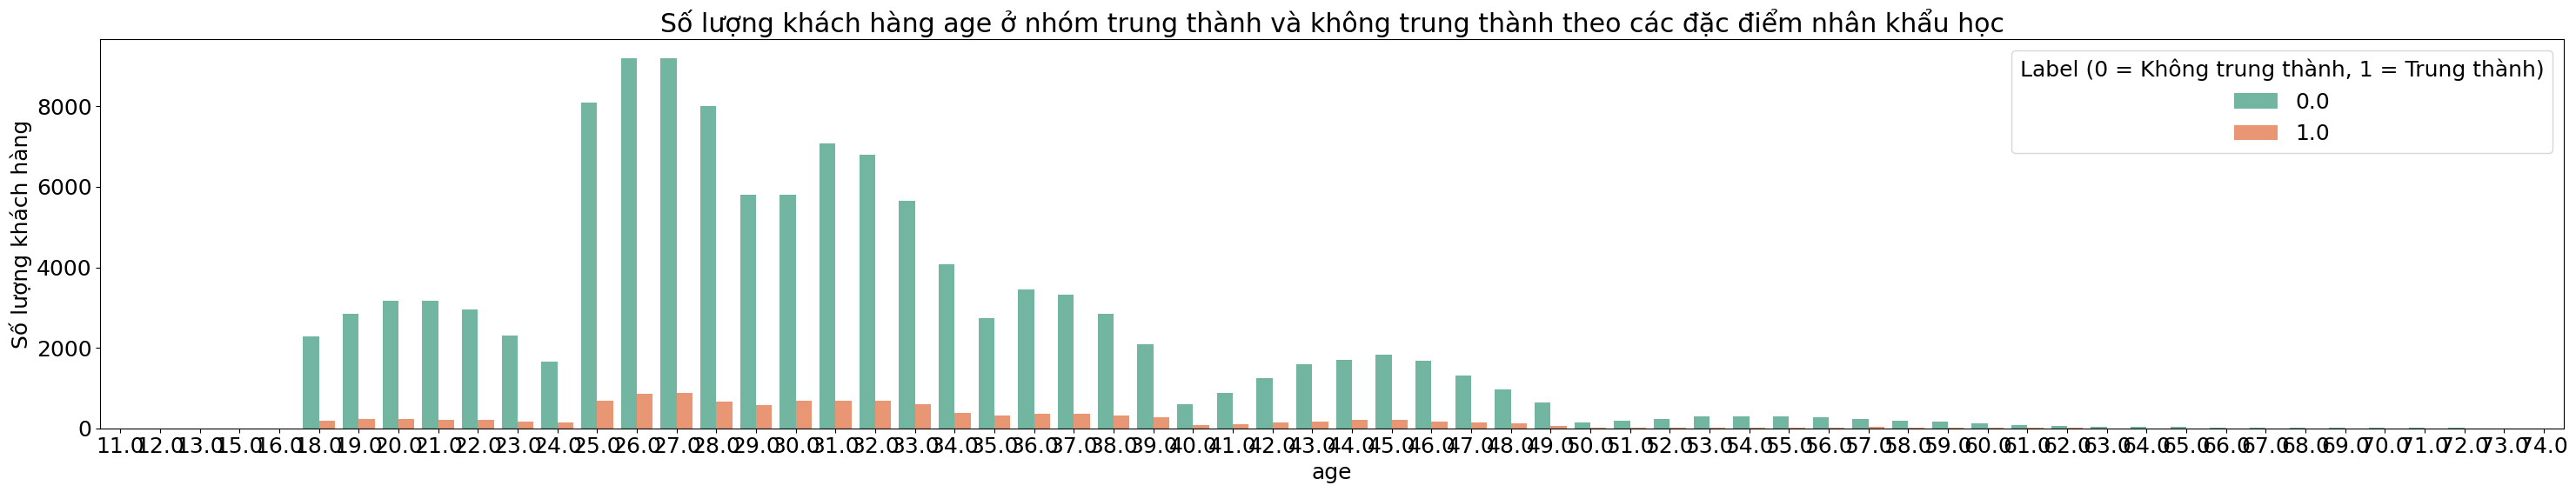

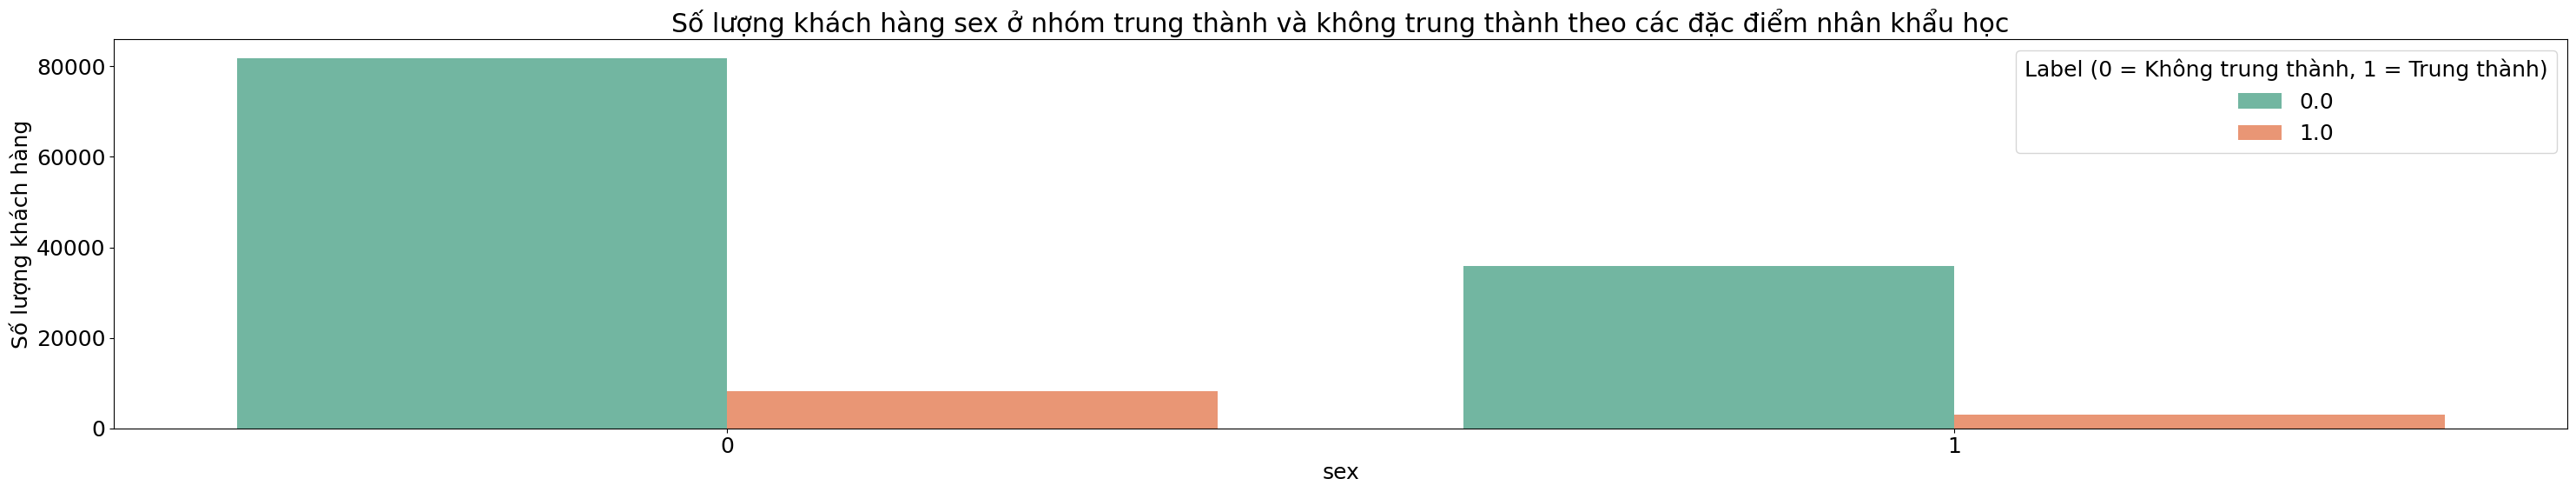

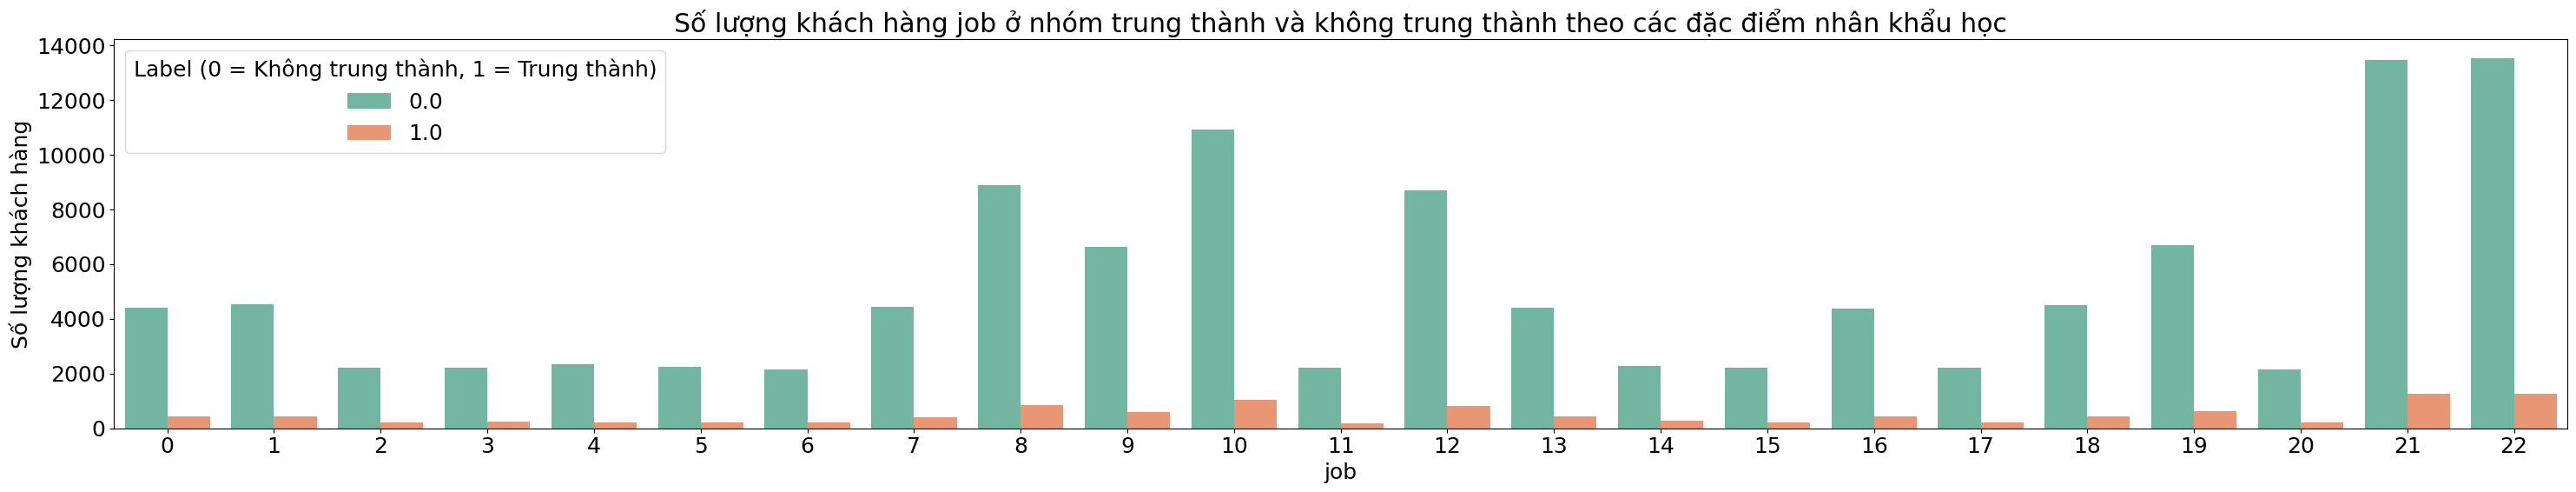

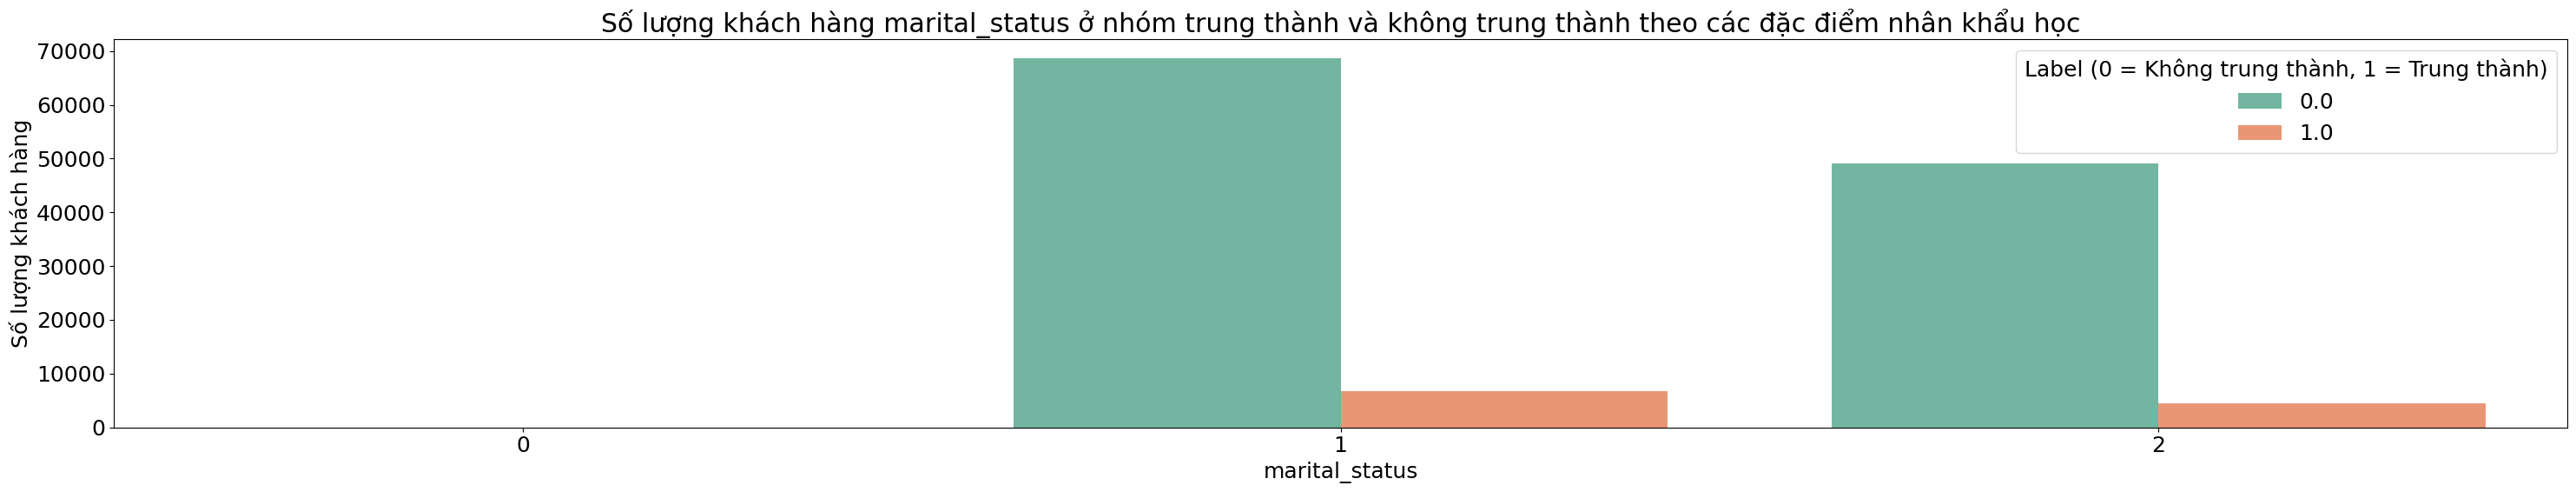

In [234]:
# Danh sách hành vi
characteristics = ['age', 'sex', 'job', 'marital_status']

# Vẽ từng biểu đồ riêng biệt
for behavior in characteristics:
    plt.figure(figsize=(30, 6))
    sns.countplot(data=data, x=behavior, hue='label', palette='Set2')
    plt.title(f'Số lượng khách hàng {behavior} ở nhóm trung thành và không trung thành theo các đặc điểm nhân khẩu học')
    plt.xlabel(f'{behavior}')
    plt.ylabel('Số lượng khách hàng')
    plt.legend(title='Label (0 = Không trung thành, 1 = Trung thành)')
    plt.tight_layout()
    plt.show()

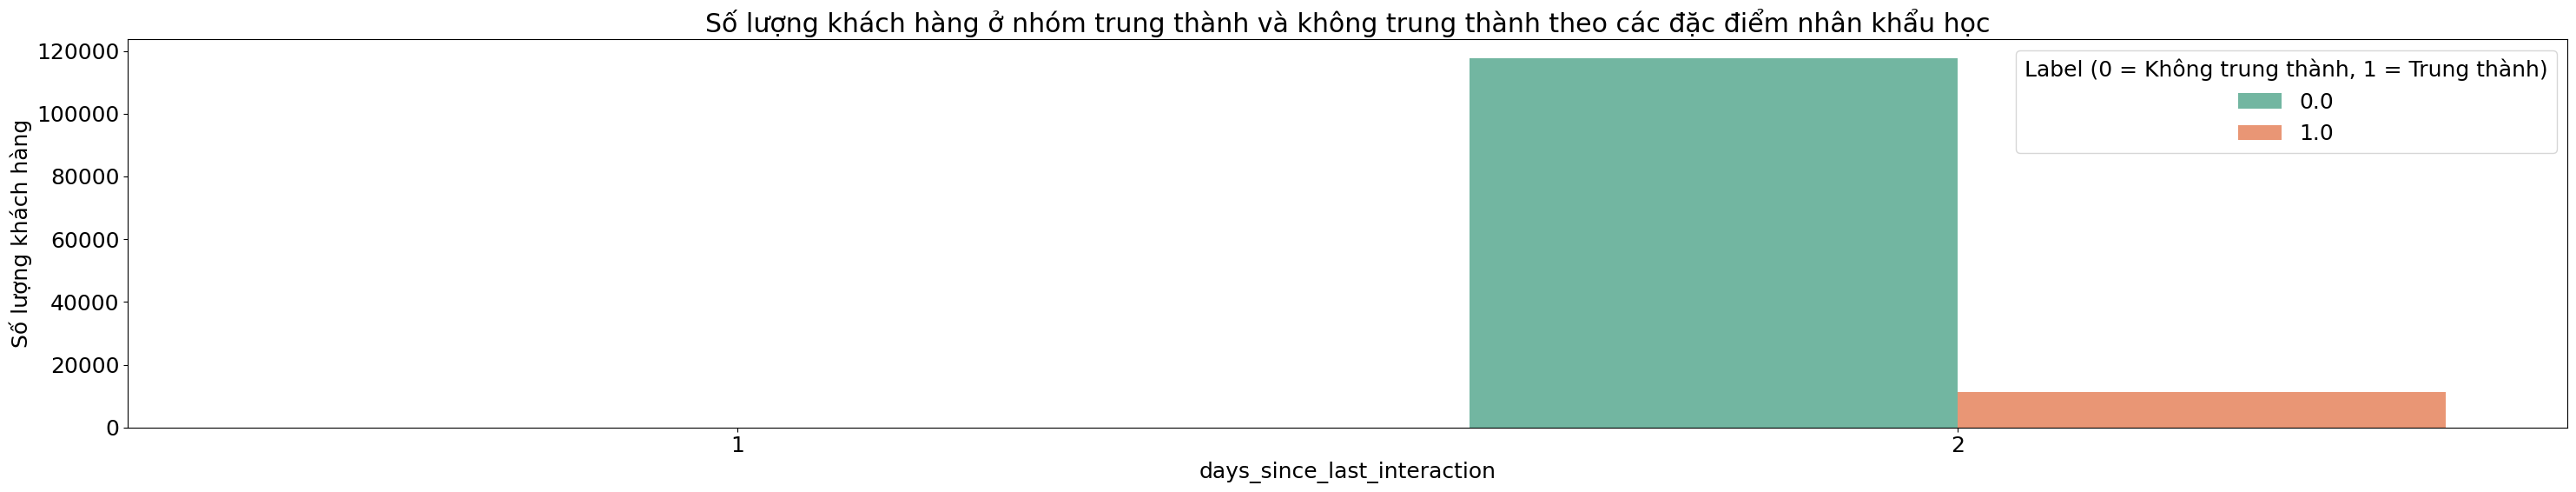

In [236]:
    plt.figure(figsize=(30, 6))
    sns.countplot(data=data, x='days_since_last_interaction', hue='label', palette='Set2')
    plt.title(f'Số lượng khách hàng ở nhóm trung thành và không trung thành theo các đặc điểm nhân khẩu học')
    plt.xlabel('days_since_last_interaction')
    plt.ylabel('Số lượng khách hàng')
    plt.legend(title='Label (0 = Không trung thành, 1 = Trung thành)')
    plt.tight_layout()
    plt.show()

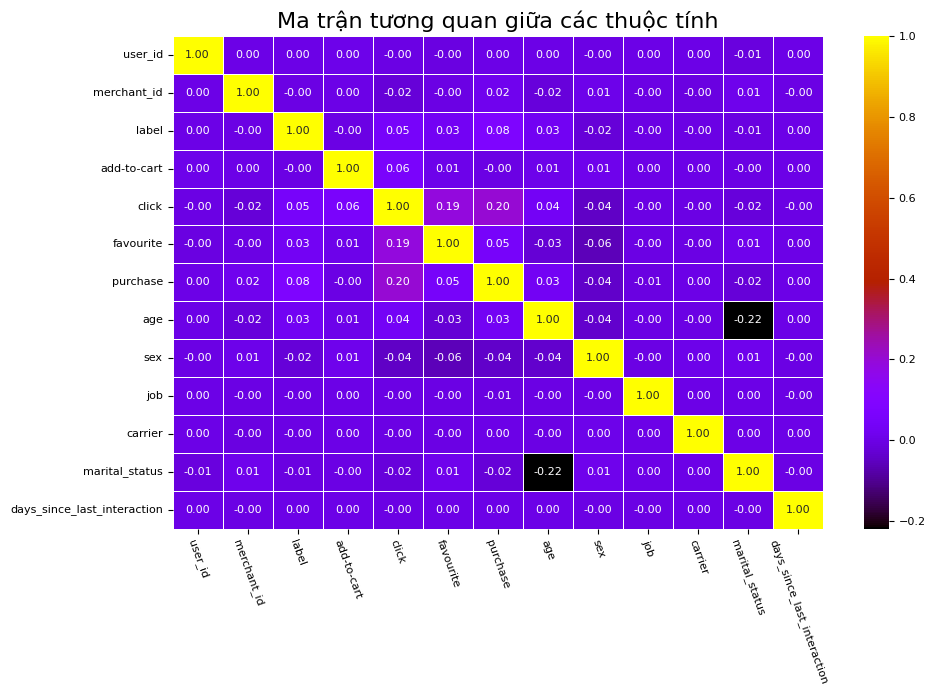

In [242]:
correlation_matrix = data.corr()

plt.rcParams['font.size'] = 8 # Đặt kích thước font cho số trên heatmap
plt.figure(figsize=(10, 7)) # Điều chỉnh kích thước biểu đồ

ax = sns.heatmap(
    data=correlation_matrix, # Dữ liệu ma trận tương quan
    cmap='gnuplot',          # Bảng màu
    annot=True,              # HIỂN THỊ GIÁ TRỊ SỐ TRÊN BIỂU ĐỒ
    fmt=".2f",               # Định dạng số thập phân (2 chữ số sau dấu phẩy)
    linewidths=.5            # Độ rộng đường kẻ giữa các ô
)

# Xoay nhãn trục X và Y để dễ đọc hơn nếu có nhiều cột
ax.tick_params(axis='x', rotation=-70)
ax.tick_params(axis='y', rotation=0)

plt.title('Ma trận tương quan giữa các thuộc tính', fontsize=16)
plt.tight_layout() # Đảm bảo bố cục chặt chẽ
plt.show()

In [ ]:
numerical_cols = ['add-to-cart', 'click', 'favourite', 'purchase', 'age', 'days_since_last_interaction']

scaler = MinMaxScaler()

data[numerical_cols] = scaler.fit_transform(data[numerical_cols])